<a href="https://colab.research.google.com/github/JoaoVitorSantiagoNogueira/deepLearning2023/blob/main/T3/DL_Task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 3

Test different auto-encoder architectures

## Theory

### references:

[1]
[2]
...

## Code

### Intialization

In [7]:
#create and train NN
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# visualize dataset
import matplotlib.pyplot as plt

# download dataset
import requests
import zipfile
from pathlib import Path
from glob import glob
import os

In [2]:
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

True


### model definition

auto encoder used on a [previous work](https://github.com/JoaoVitorSantiagoNogueira/tcc-testes), removing the middle layers as no processing needs to be done. This will serve as our baseline. Steal model concatenation from task2

we *are not* using skip conections, since we are just reconstructing images and skip connections would allow us to cheat by skipping the network entirely.   

In [3]:

class BaseNetwork(nn.Module):
    def __init__(self):
        super(BaseNetwork, self).__init__()

    def init_weights(self, init_type='normal', gain=0.02):
        '''
        initialize network's weights
        init_type: normal | xavier | kaiming | orthogonal
        https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/9451e70673400885567d08a9e97ade2524c700d0/models/networks.py#L39
        '''

        def init_func(m):
            classname = m.__class__.__name__
            if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
                if init_type == 'normal':
                    nn.init.normal_(m.weight.data, 0.0, gain)
                elif init_type == 'xavier':
                    nn.init.xavier_normal_(m.weight.data, gain=gain)
                elif init_type == 'kaiming':
                    nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
                elif init_type == 'orthogonal':
                    nn.init.orthogonal_(m.weight.data, gain=gain)

                if hasattr(m, 'bias') and m.bias is not None:
                    nn.init.constant_(m.bias.data, 0.0)

            elif classname.find('BatchNorm2d') != -1:
                nn.init.normal_(m.weight.data, 1.0, gain)
                nn.init.constant_(m.bias.data, 0.0)

        self.apply(init_func)


In [4]:
class AutoEncoder(BaseNetwork):
    def __init__(self, residual_blocks=8, init_weights=True):
        super(AutoEncoder, self).__init__()


        ### keeps height and width the same, halves the number of channels, size = 1/2 * Hi * Wi
        self.encoder1 = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels=4, out_channels=2, kernel_size=7, padding=0),
            nn.InstanceNorm2d(2, track_running_stats=False),
            nn.ReLU(True),

        )
        ### halves height and width, keeps the number of channels, size = 1/4 * Hi * Wi
        self.encoder2 = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=2, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(2, track_running_stats=False),
            nn.ReLU(True),
        )
        ### halves height, width and number of channels, size = 1/16 * Hi * Wi
        self.encoder3 = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=1, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(1, track_running_stats=False),
            nn.ReLU(True)
        )


        ### doubles height, width and number of channels, size = 1/4 * Hi * Wi
        self.decoder1 = nn.Sequential(
            #nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1),
            #changes to avoid chckered patterns, parameters chosen to keep the same dimensions
            nn.Upsample(scale_factor= 4, mode='bilinear'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels=1, out_channels=2, kernel_size=4, stride=2, padding=0),
            # [batch_size, 128, 128, 128]
            nn.InstanceNorm2d(2, track_running_stats=False),
            nn.ReLU(True),
        )

        ### doubles height and width the same, keeps the number of channels, size = 1/2 * Hi * Wi
        self.decoder2 = nn.Sequential(
            #nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.Upsample(scale_factor= 4, mode='bilinear'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels=2, out_channels=2, kernel_size=4, stride=2, padding=0),
            # [batch_size, 64, 256, 256]
            nn.InstanceNorm2d(2, track_running_stats=False),
            nn.ReLU(True),
        )

        ### keeps height and width the same, doubles the number of channels, size = Hi * Wi
        self.decoder3 = nn.Sequential(
            nn.ReflectionPad2d(3),
            # [batch_size, 64, 262, 262]
            nn.Conv2d(in_channels=2, out_channels=4, kernel_size=7, padding=0),
            # [batch_size, 3, 256, 256]
        )

        if init_weights:
            self.init_weights()

    def forward(self, x):
        down1 = self.encoder1(x)
        down2 = self.encoder2(down1)
        down3 = self.encoder3(down2)
        ## now go up
        up1 = self.decoder1(down3)
        up2 = self.decoder2(up1)
        up3 = self.decoder3(up2)
        x = (torch.tanh(x) + 1) / 2

        return x

sanity check

989 total parameters.
989 training parameters.
torch.Size([1, 4, 512, 512])


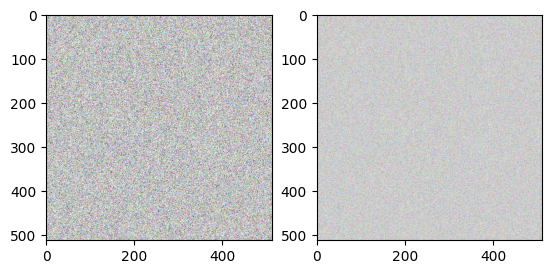

In [5]:
input_image = torch.rand((1, 4, 512, 512))
check_model = AutoEncoder()

#Total parameters and trainable parameters.
total_params = sum(p.numel() for p in check_model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in check_model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

outputs = check_model(input_image)
print(outputs.shape)

f, axarr = plt.subplots(1,2)

#the 0th image of the 'batch', changing channels to match the right order.
axarr[0].imshow(input_image[0].permute(1, 2, 0))
axarr[1].imshow(outputs[0].permute(1, 2, 0), cmap="gray")


### Model Initialization

In [8]:
### Assamble Model
loss_function = F.binary_cross_entropy_with_logits
learning_rate = 0.001

AE = AutoEncoder(1)
AE.to(device)

optimizer = torch.optim.Adam(AE.parameters(), lr=learning_rate)
print(AE)

AutoEncoder(
  (encoder1): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(4, 2, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(2, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(2, 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(2, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (encoder3): Sequential(
    (0): Conv2d(2, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (decoder1): Sequential(
    (0): Upsample(scale_factor=4.0, mode='bilinear')
    (1): ReflectionPad2d((1, 1, 1, 1))
    (2): Conv2d(1, 2, kernel_size=(4, 4), stride=(2, 2))
    (3): InstanceNorm2d(2, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): ReLU(inplace=Tr

### Dataset Loading

In [ ]:
def loadDatasetZipFromDrive(link, data_path = "data/",folder = "imgs"):


  # Setup path to data folder
  data_path = Path(data_path)
  image_path = data_path / folder

  # If the image folder doesn't exist, download it and prepare it...
  if image_path.is_dir():
      print(f"{image_path} directory exists.")
  else:
      print(f"Did not find {image_path} directory, creating one...")
      image_path.mkdir(parents=True, exist_ok=True)

      # Download pizza, steak, sushi data
      with open(data_path / (folder + ".zip"), "wb") as f:
          request = requests.get(link)
          print("Downloading dataset...")
          f.write(request.content)

      # Unzip pizza, steak, sushi data
      with zipfile.ZipFile(data_path / (folder + ".zip"), "r") as zip_ref:
          print("Unzipping dataset...")
          zip_ref.extractall(image_path)


  # no labels, since each input image is the desired output

  TRAIN_IMAGE_ROOT = "./" + str(image_path) + "/training/input"
  #TRAIN_LABEL_ROOT = "./data/RETINA/training/target"

  TEST_IMAGE_ROOT = "./" + str(image_path) +"/input"
  #TEST_LABEL_ROOT = "./data/RETINA/test/target"

  images = sorted(glob(os.path.join(TRAIN_IMAGE_ROOT, "*training.tif")))
  #labels = sorted(glob(os.path.join(TRAIN_LABEL_ROOT, "*manual1.png")))

  testimages = sorted(glob(os.path.join(TEST_IMAGE_ROOT, "*test.tif")))
  #testlabels = sorted(glob(os.path.join(TEST_LABEL_ROOT, "*manual1.gif")))

  #return images, label, testimages, testlabels
  return images, testimages

In [ ]:
loadDatasetZipFromDrive(link= "https://drive.google.com/u/0/uc?id=10Uy_UT0JgjCTCcirzTGs5_nNDmH_MryX&export=download&confirm=t&uuid=211af45b-bdaa-4f76-aed9-5c786d7173e4&at=AB6BwCALI4ZjjkzYftiUni1t1842:1697461941658")

data/imgs directory exists.


(['./data/imgs/training/input/21_training.tif',
  './data/imgs/training/input/22_training.tif',
  './data/imgs/training/input/23_training.tif',
  './data/imgs/training/input/24_training.tif',
  './data/imgs/training/input/25_training.tif',
  './data/imgs/training/input/26_training.tif',
  './data/imgs/training/input/27_training.tif',
  './data/imgs/training/input/28_training.tif',
  './data/imgs/training/input/29_training.tif',
  './data/imgs/training/input/30_training.tif',
  './data/imgs/training/input/31_training.tif',
  './data/imgs/training/input/32_training.tif',
  './data/imgs/training/input/33_training.tif',
  './data/imgs/training/input/34_training.tif',
  './data/imgs/training/input/35_training.tif',
  './data/imgs/training/input/36_training.tif',
  './data/imgs/training/input/37_training.tif',
  './data/imgs/training/input/38_training.tif',
  './data/imgs/training/input/39_training.tif',
  './data/imgs/training/input/40_training.tif'],
 [])

###Training

### Usage

### Visualization
